In [1]:
# Written by W.T. Chung

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import os

In [2]:
tf.keras.utils.set_random_seed(812)

# This will make TensorFlow ops as deterministic as possible, but it will
# affect the overall performance, so it's not enabled by default.
# `enable_op_determinism()` is introduced in TensorFlow 2.9.
tf.config.experimental.enable_op_determinism()

input_path = './dataset/'

In [3]:
#taken from keras tutorial: https://keras.io/examples/vision/edsr/
from tensorflow.keras import layers
from tensorflow.keras.models import Model


# Residual Block

def ResBlock(inputs):
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(inputs)
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.Add()([inputs, x])
    return x


# Upsampling Block
def Upsampling(inputs, factor=2, **kwargs):
    x = layers.Conv2D(64 * (factor ** 2), 3, padding="same", **kwargs)(inputs)
    x = tf.nn.depth_to_space(x, block_size=factor)
    x = layers.Conv2D(64 * (factor ** 2), 3, padding="same", **kwargs)(x)
    x = tf.nn.depth_to_space(x, block_size=factor)
    x = layers.Conv2D(64 * (factor ** 2), 3, padding="same", **kwargs)(x)
    x = tf.nn.depth_to_space(x, block_size=factor)
    return x


def make_model(num_filters=64, num_of_residual_blocks=16):
    # Flexible Inputs to input_layer
    input_layer = layers.Input(shape=(None, None, 1))
    # Scaling Pixel Values
    x = x_new = layers.Conv2D(num_filters, 3, padding="same")(input_layer)

    # 16 residual blocks
    for _ in range(num_of_residual_blocks):
        x_new = ResBlock(x_new)

    x_new = layers.Conv2D(num_filters, 3, padding="same")(x_new)
    x = layers.Add()([x, x_new])

    x = Upsampling(x)
    output_layer = layers.Conv2D(1, 3, padding="same")(x)

    return Model(input_layer, output_layer)

model = make_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 1)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 64)       640       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, None, None, 64)       36928     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, None, None, 64)       36928     ['conv2d_1[0][0]']            
                                                                                              

In [4]:
#get filenames
def getFiles(mode = "train",scalar = 'YOH'):
    HR_path = input_path + "HR/"+scalar+'/' + mode
    files = os.listdir(HR_path)
    train_files = []
    for idx,file in enumerate(files):
        if file.startswith('YOH'):
            train_files.append(file)
    for idx,file in enumerate(train_files):
        train_files[idx] = file[3:]
    return train_files

In [5]:
train_files = getFiles()
val_files =  getFiles('val')
test_files =  getFiles('test')

In [6]:

my_mean = 0.003057
my_std = 0.002693
def getXY(idx,filenames,mode = "train",scalar = 'YOH'):
    LR_path = input_path + "LR/"+scalar+'/' + mode
    HR_path = input_path + "HR/"+scalar+'/' + mode

    X = (np.fromfile(LR_path + "/"+scalar + filenames[idx], dtype="<f4").reshape(16,16,1) - my_mean)/my_std
    Y = (np.fromfile(HR_path + "/"+scalar + filenames[idx], dtype="<f4").reshape(128,128,1)- my_mean)/my_std
    X = tf.convert_to_tensor(X,dtype=tf.float32)
    Y = tf.convert_to_tensor(Y,dtype=tf.float32)
    return [X,Y]

def getTrainXY(idx):
    return getXY(idx,train_files,mode = "train")

def getValXY(idx):
    return getXY(idx,val_files,mode = "val")
def getTestXY(idx):
    return getXY(idx,val_files,mode = "test")


In [7]:
X0,Y0 = getXY(0,train_files,mode = "train")
print("Feature shapes:")
print( X0.shape)
print("Label shapes:")
print( Y0.shape)

nx_in, ny_in, nc_in = X0.shape
nx_out, ny_out, nc_out = Y0.shape

Feature shapes:
(16, 16, 1)
Label shapes:
(128, 128, 1)


In [8]:
#create directories for checkpoints and logs
log_dir =  "./logs"
checkpoint_dir =  "./ckpt"

# Either restore the latest model, or create a fresh one if there is no checkpoint available.
def make_or_restore_model(alpha=1e-3,checkpoint_dir=checkpoint_dir,ckpt=None):
    model =  make_model()
    #set up save/load checkpoints
    if ckpt:
      latest_checkpoint = checkpoint_dir + "/ckpt-" +str(ckpt)
      print("Restoring from", latest_checkpoint)
      nckpt = int(latest_checkpoint.split('-')[-1])
      restored_model =  tf.keras.models.load_model(latest_checkpoint)
      model.set_weights(restored_model.get_weights())
    else:
      checkpoints = [checkpoint_dir + "/" + name for name in os.listdir(checkpoint_dir)]
      nckpt = 0
      if checkpoints:
          latest_checkpoint = max(checkpoints, key=os.path.getctime)
          print("Restoring from", latest_checkpoint)
          nckpt = int(latest_checkpoint.split('-')[-1])
          restored_model =  tf.keras.models.load_model(latest_checkpoint)
          model.set_weights(restored_model.get_weights())
      else:
          print("Creating a new model")

    #compile model with optimizerloss functions,metrics
    #NOTE: Although we're only using MSE as the public metric here, we will be also evaluating with SSIM-based metrics to search for best models so you may want to monitor other metrics
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=alpha),
        loss=tf.keras.losses.MeanSquaredError(reduction='sum_over_batch_size'),
           metrics =[tf.keras.metrics.MeanAbsoluteError()]) #add other metrics here

    return [model,nckpt]

In [9]:
modelscratch = make_or_restore_model(ckpt=249,checkpoint_dir='./outputScratch/'+checkpoint_dir)[0]

Restoring from ./outputScratch/./ckpt/ckpt-249


In [10]:
modelfinetuned = make_or_restore_model(checkpoint_dir=checkpoint_dir,ckpt=137)[0]

Restoring from ./ckpt/ckpt-137


Feature shapes:
(1, 16, 16, 1)
Label shapes:


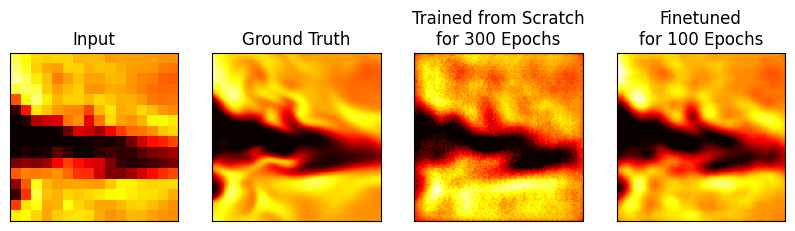

In [11]:
X0,Y0 = getXY(3,test_files,mode = "test")
print("Feature shapes:")
print( X0[None].shape)
print("Label shapes:")

YhatScratch = modelscratch(X0[None])

YhatFT= modelfinetuned(X0[None])

fig, axs = plt.subplots(1, 4, figsize=(10, 5))
cmap = 'hot'
axs[0].set_title("Input")
im = axs[0].imshow(X0,cmap=cmap)
im.set_clim(-1,2)
axs[1].set_title("Ground Truth")
im = axs[1].imshow(Y0,cmap = cmap)
im.set_clim(-1,2)

im = axs[2].imshow(YhatScratch[0,:,:,0],cmap = cmap)
axs[2].set_title("Trained from Scratch\nfor 300 Epochs")

im.set_clim(-1,2)
axs[3].set_title("Finetuned\nfor 100 Epochs")

im = axs[3].imshow(YhatFT[0,:,:,0],cmap = cmap)
im.set_clim(-1,2)

for ax in axs:
  ax.set_xticks([])
  ax.set_yticks([])



# Loss plots

In [12]:
df= pd.read_csv('./outputScratch/logs/model_history_log.csv')
df = df.drop_duplicates("epoch",keep='last')

In [13]:
pt_df = pd.read_csv("./logs/model_history_log.csv")
pt_df = pt_df.drop_duplicates("epoch",keep='last')

Text(30, 0.04, 'Fine-tuning')

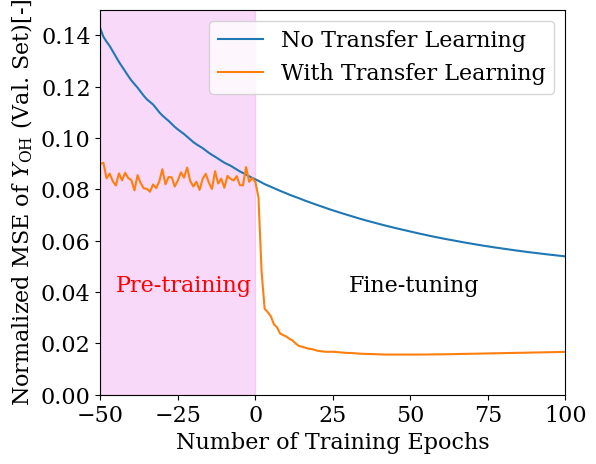

In [15]:
# plt.plot(df['epoch']-10-93,df["loss"])
plt.figure(figsize=(6,5))
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rcParams["font.size"] = 16
plt.plot(df['epoch']-1-90,df["val_loss"],label = 'No Transfer Learning')


# plt.plot(pt_df['epoch']-93,pt_df["loss"])

plt.plot(pt_df['epoch']-90,pt_df["val_loss"],label='With Transfer Learning')
# plt.plot((pt_df['epoch'][0:93]-93)*173,pt_df["val_loss"][0:93],label='With Transfer Learning')
plt.fill_between([-50,0], [0.2,0.2], color='violet', alpha=0.3)
plt.ylabel("Normalized MSE of $Y_\mathrm{OH}$ (Val. Set)[-]")
plt.legend()
plt.xlabel("Number of Training Epochs")
plt.xlim([-50,100])
plt.ylim([0,0.15])
plt.text(-45,0.04, "Pre-training",color='r')
plt.text(30,0.04, "Fine-tuning")


